<a href="https://colab.research.google.com/github/iguerrasevillano/TFM/blob/clean_version/Extractive_summaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [1]:
!pip install tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0
    Uninstalling te

In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
import json

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Keras
import tensorflow as tf

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist

nltk.download('punkt')

# Graph
import networkx as nx
import re

# Time
import time

# AST
import ast

# Current directory
os.getcwd()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'/content'

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


### Load and clean raw data

In [4]:
# Connect w/ Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
BASE_PATH = "/content/drive/MyDrive/VIU/TFM/Desarrollo/Data/"

documents = os.listdir(BASE_PATH)

In [4]:
# AUXILIAR FUNCTIONS

def load_data(data):

  jsonl_file_path = BASE_PATH + 'TLDR/' + data + '.jsonl'

  # Read the JSON Lines file into a list of dictionaries
  data_list = []
  with open(jsonl_file_path, 'r') as jsonl_file:
      for line in jsonl_file:
          data_dict = json.loads(line)
          data_list.append(data_dict)

  return data_list



# Join all the sentences of target
def join_words(df, column):
  df[column] = df[column].apply(lambda x : ' '.join(x))
  return df


# Count number of words of target
def count_words(df, column):
  return df[column].apply(lambda x : len(x.split()))



def similarity(sentence1, sentence2, stopwords=None):
  if stopwords is None:
    stopwords = []
  sentence1 = [w.lower() for w in sentence1]
  sentence2 = [w.lower() for w in sentence2]

  all_words = list(set(sentence1 + sentence2))

  vector1 = [0] * len(all_words)
  vector2 = [0] * len(all_words)

  #build the vector for the first sentence
  for word in sentence1:
    if not word in stopwords:
      vector1[all_words.index(word)]+=1

  #build the vector for the second sentence
  for word in sentence2:
    if not word in stopwords:
      vector2[all_words.index(word)]+=1

  norm_vector1 = np.sqrt(np.dot(vector1, vector1))
  norm_vector2 = np.sqrt(np.dot(vector2, vector2))

  if norm_vector1 == 0 or norm_vector2 == 0:
    return 0

  return 1-cosine_distance(vector1, vector2)



def similarity_matrix(sentences, stop_words):
  similarity_matrix = np.zeros((len(sentences), len(sentences)))

  for idx1 in range(len(sentences)):
    for idx2 in range(len(sentences)):
      if idx1 != idx2:
        similarity_matrix[idx1][idx2] = similarity(sentences[idx1], sentences[idx2], stop_words)

  return similarity_matrix



def generate_extractive_summary(sentences, top_n, stop_words):

  summarize_text = []

  # Step1: generate similarity matrix
  sentence_similarity_matrix = similarity_matrix(sentences, stop_words)

  # Step2: Rank sentences in similarity matrix
  sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
  scores = nx.pagerank(sentence_similarity_graph)

  # Step3: sort the rank and place top sentences
  ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

  # Step4: get the top n number of sentences based on rank
  for i in range(top_n):
    if len(ranked_sentences) > i:
      summarize_text.append(ranked_sentences[i][1])
    else:
      break

  # Step5: reorder the sentences as in the original text
  real_indexes = []
  for sentence in summarize_text:
    if sentence in sentences:
      real_indexes.append(sentences.index(sentence))
    else:
      continue

  sorted_real_indexes = sorted(real_indexes)

  ordered_summarized_text = []
  for i in sorted_real_indexes:
    ordered_summarized_text.append(sentences[i])

  # Step6 : output the summarized version
  return ' '.join(ordered_summarized_text)

In [47]:
data_list = load_data('train')
data_list.extend(load_data('dev'))
data_list.extend(load_data('test'))

# Convert the list of dictionaries to a Pandas DataFrame
data = pd.DataFrame(data_list)

# Display the DataFrame
display(data.head())
print(data['source'][0])

,source,source_labels,rouge_scores,paper_id,target,title
0,[Due to the success of deep learning to solvin...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.3018867874688502, 0.37209301838831804, 0.60...",SysEexbRb,[We provide necessary and sufficient analytica...,NaN
1,[The backpropagation (BP) algorithm is often t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.13043477920604923, 0.142857139229...",SygvZ209F7,"[Biologically plausible learning algorithms, p...",NaN
2,"[We introduce the 2-simplicial Transformer, an...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.33333332839506175, 0.8888888839111112, 0.11...",rkecJ6VFvr,[We introduce the 2-simplicial Transformer and...,NaN
3,"[We present Tensor-Train RNN (TT-RNN), a novel...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06666666222222252, 0.06451612466181092, 0.0...",HJJ0w--0W,[Accurate forecasting over very long time hori...,NaN
4,[Recent efforts on combining deep models with ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2777777727932099, 0.5714285666581633, 0.095...",HyH9lbZAW,[We propose a variational message-passing algo...,NaN


['Due to the success of deep learning to solving a variety of challenging machine learning tasks, there is a rising interest in understanding loss functions for training neural networks from a theoretical aspect.', 'Particularly, the properties of critical points and the landscape around them are of importance to determine the convergence performance of optimization algorithms.', 'In this paper, we provide a necessary and sufficient characterization of the analytical forms for the critical points (as well as global minimizers) of the square loss functions for linear neural networks.', 'We show that the analytical forms of the critical points characterize the values of the corresponding loss functions as well as the necessary and sufficient conditions to achieve global minimum.', 'Furthermore, we exploit the analytical forms of the critical points to characterize the landscape properties for the loss functions of linear neural networks and shallow ReLU networks.', 'One particular conclu

##  EDA

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3229 entries, 0 to 3228
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   source         3229 non-null   object
 1   source_labels  3229 non-null   object
 2   rouge_scores   3229 non-null   object
 3   paper_id       3229 non-null   object
 4   target         3229 non-null   object
 5   title          1237 non-null   object
dtypes: object(6)
memory usage: 151.5+ KB


In [49]:
data_eda = data.copy()

data_eda =  join_words(data_eda, 'target')
data_eda = join_words(data_eda, 'source')

data_eda['number_words_source'] = count_words(data_eda, 'source')
data_eda['number_words_target'] = count_words(data_eda, 'target')

print(data_eda.describe())

       number_words_source  number_words_target
count          3229.000000          3229.000000
mean           4981.847011            34.522453
std            2177.307224            24.459065
min              37.000000             3.000000
25%            3872.000000            16.000000
50%            4870.000000            24.000000
75%            6071.000000            51.000000
max           25303.000000           149.000000


Text(0.5, 0, 'Nº of words in target')

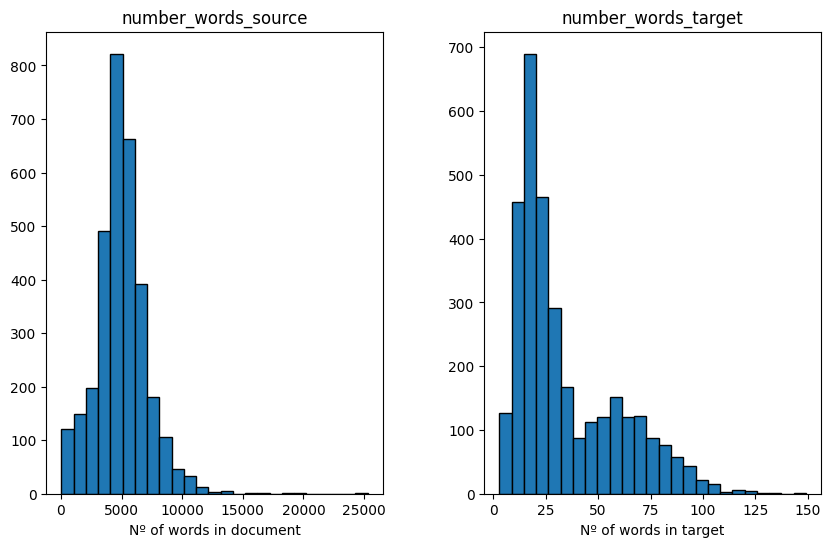

In [50]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))

data_eda.hist(ax=ax,
              bins=25,
              edgecolor='black',
              grid=False)

ax[0].set_xlabel('Nº of words in document')
ax[1].set_xlabel('Nº of words in target')

In [54]:
data_eda['compression_ratio'] = 100 * data_eda['number_words_target'] / data_eda['number_words_source']
data_eda['number_sent_source'] = data['source'].apply(lambda x : len(x))
data_eda['number_words_per_sent'] = data_eda['number_words_source'] / data_eda['number_sent_source']

In [55]:
data_eda.describe()

,number_words_source,number_words_target,compression_ratio,number_sent_source,number_words_per_sent
count,3229.000000,3229.000000,3229.000000,3229.000000,3229.000000
mean,4981.847011,34.522453,1.272574,212.537628,23.742562
std,2177.307224,24.459065,3.981990,96.251028,3.560765
min,37.000000,3.000000,0.026082,2.000000,11.727273
25%,3872.000000,16.000000,0.329637,162.000000,21.363636
50%,4870.000000,24.000000,0.570676,207.000000,23.440758
75%,6071.000000,51.000000,1.144258,257.000000,25.714844
max,25303.000000,149.000000,69.387755,1101.000000,53.203209


768

In [10]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

words = []
counter = []

corpus  =  ' '.join(list(data_eda['source']))
corpus_list = word_tokenize(corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
puntuaction_marks = [',', '.', ':', '?', '!', ';', ')', '(']

freq = FreqDist(word.lower() for word in corpus_list
                if word.lower() not in stop_words+puntuaction_marks)

In [12]:
most_common_words =  pd.Series(freq).sort_values(ascending=False)
top30 =  most_common_words[:30]

In [13]:
most_common_words

1                  75854
model              66220
x                  62351
=                  58023
training           55892
                   ...  
compositionalor        1
gaddy                  1
ouyang                 1
out=6                  1
language-only          1
Length: 159666, dtype: int64

<ipython-input-14-e24783bf9416>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top30.values,


Text(0.5, 1.0, 'Top 30 words')

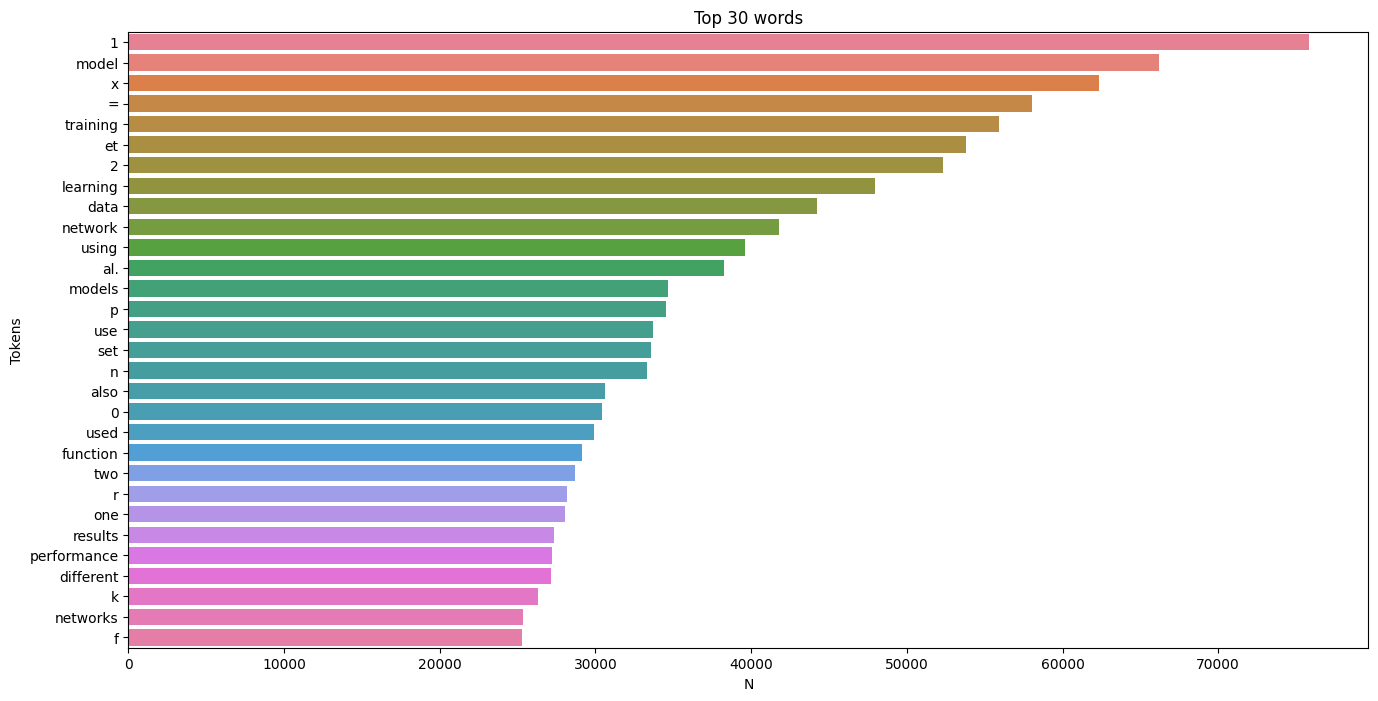

In [14]:
palette = 'husl'

plt.figure(figsize=(16, 8))
sns.barplot(x=top30.values,
            y=top30.index,
            palette=palette)

plt.xlabel('N')
plt.ylabel('Tokens')
plt.title('Top 30 words')

In [59]:
# Drop columns
no_need_columns = ['source_labels', 'rouge_scores']
data = data.drop(columns=no_need_columns)

data = join_words(data, 'target')

data['number_words_target'] = count_words(data, 'target')

print(data['number_words_target'].describe())

count    3229.000000
mean       34.522453
std        24.459065
min         3.000000
25%        16.000000
50%        24.000000
75%        51.000000
max       149.000000
Name: number_words_target, dtype: float64


In [ ]:
# Summaries with less than30 words are eliminated from the data
clean_data = data[data['number_words_target']>=30]
clean_data = clean_data.reset_index(drop=True)

clean_data['number_words_target'].describe()

In [ ]:
clean_data['extractive_summary'] = np.nan
clean_data.head()

In [ ]:
#RESET DATA
import ast

clean_data = pd.read_csv(BASE_PATH+'extractive_summaries+good.csv')

# Assuming 'df' is your DataFrame and 'list_column' is the column with lists
# For example, if your DataFrame looks like this:
# df = pd.DataFrame({'list_column': [[1, 2, 3], [4, 5], [6, 7, 8]]})

# Define a function to safely convert strings to lists
def convert_to_list(cell):
    try:
        return ast.literal_eval(cell)
    except (SyntaxError, ValueError):
        return cell

# Apply the function to the column with lists
clean_data['source'] = clean_data['source'].apply(convert_to_list)

# Now, 'list_column' contains lists
# Access the first list in the first row, for example
first_list = clean_data.at[0, 'source']
print(first_list)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
top_n = 16
total = clean_data.shape[0]
prev_index = 0

reset_from = 990

for index in range(reset_from, total):
  if index % 10 == 0:
    if (prev_index+10) == index:
      end_time = time.time()
      print(f'{int(end_time - start_time)}s')
    print(f'[INFO]: generating summary {index}/{total}...')
    prev_index = index
    start_time = time.time()
    clean_data.to_csv(BASE_PATH+'extractive_summaries_good.csv', index=False)

  clean_data['extractive_summary'][index] = generate_extractive_summary(clean_data['source'][index],
                                                                        top_n,
                                                                        stop_words)

clean_data.to_csv(BASE_PATH+'extractive_summaries+good.csv', index=False)

In [ ]:
  clean_data['extractive_summary'][1311]


In [ ]:
clean_data['sentences_extractive_summary'] = clean_data['extractive_summary'].apply(sent_tokenize)

In [ ]:
print(clean_data['sentences_extractive_summary'][1])
print(clean_data['source'][1])

In [ ]:
a = clean_data['source'][1]
for i in range(len(a)):
  if '(A1)' in a[i]:
    print(i)
    print(a[i])

In [ ]:
"Therefore, it is reasonable to hypothesize that the reasons for the success of GANs in modeling natural images come from two complementary sources: (A1) Leveraging the powerful inductive bias of deep convnets." in clean_data['source'][1]

In [ ]:
clean_data['number_words_extractive'] = count_words(clean_data, 'extractive_summary')

clean_data.describe()

In [ ]:
i = 1
print(clean_data['source'][i])
print(clean_data['target'][i])
print(clean_data['extractive_summary'][i])
print(clean_data['number_words_extractive'][i])
print(clean_data['number_words_extractive'][i])

In [ ]:
# Assuming 'summarize_text' is a string
summarize_text = "This is the first sentence. This is the second sentence. And this is the third sentence."

# Split the string into a list of sentences
list_of_sentences = sent_tokenize(summarize_text)

# Print the result
print(list_of_sentences)